In [57]:
import math
import random 
from collections import defaultdict
from pprint import pprint

# prevent future depreciation and warnning
import warnings 
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

sns.set_style(style='white')
sns.set_context(context='notebook', font_scale=1.3, rc={'figure.figsize': (16,9)})

Importing data using the Python Reddit API Wrapper

In [ ]:
d1 = pd.read_csv("comments_1.csv")
d2 = pd.read_csv("comments_2.csv")
df = pd.concat([d1,d2], ignore_index=True)
df.head()

In [3]:
# update = {'-1' : -1}
# df.label = [update[item] for item in df.label]

In [59]:
df.label.value_counts()

label
-1    8449
 0    5792
Name: count, dtype: int64

In [ ]:
from wordcloud import WordCloud
bad_words = ' '.join(list(df[df['label'] == -1]['headline']))
bad_words_wc = WordCloud(width = 512,height = 380).generate(bad_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(bad_words_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
#plt.show()

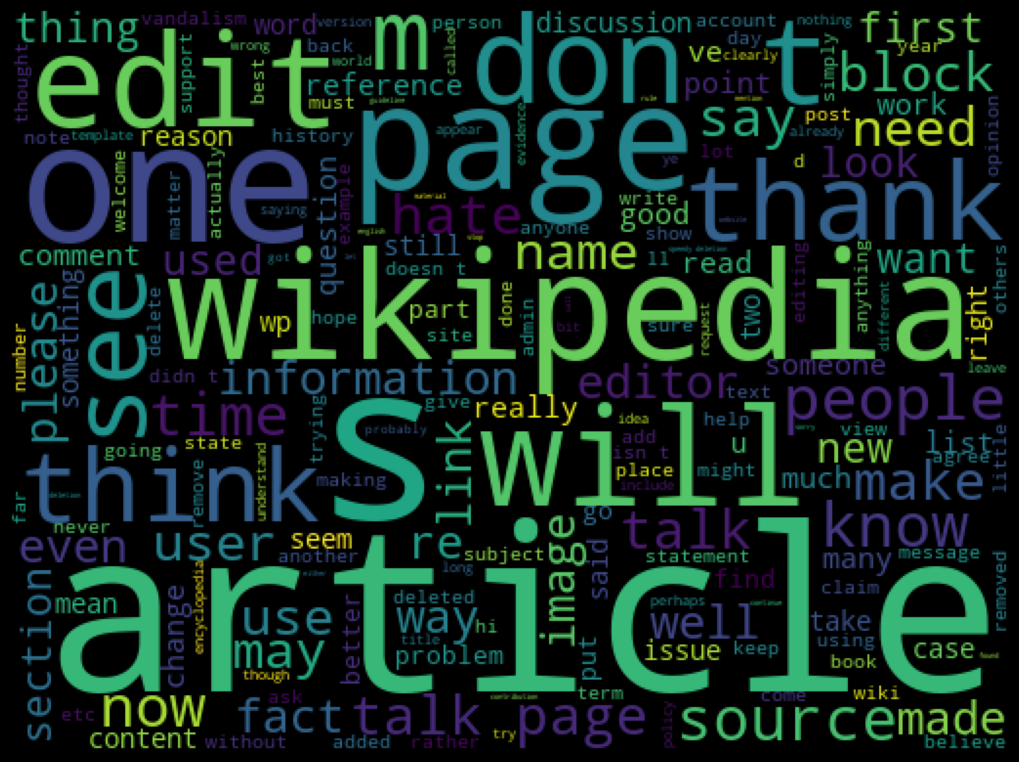

In [61]:
from wordcloud import WordCloud
non_badword = ' '.join(list(df[df['label'] == 0]['headline']))
non_badword_wc = WordCloud(width = 512,height = 380).generate(non_badword)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(non_badword_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [7]:
# print(df.columns)
# df.columns=['x','y']
# print(df)
# what = df['y'].value_counts()
# print(what)

# x=pd.DataFrame(what)
# x['x']=['-1','0','1']
# print(x)
# x.to_json(orient='records')
# # what=(pd.DataFrame(what))
# # print(what.columns)


In [62]:
# df = df[df.label!=0]
df['label'].value_counts()

label
-1    8449
 0    5792
Name: count, dtype: int64

In [63]:
#Transform headline into features
from sklearn.feature_extraction.text import CountVectorizer

s1 = "Senate panel moving ahead with Mueller bill despite McConnell opposition"
s2 = "Bill protecting Robert Mueller to get vote despite McConnell opposition"

vect = CountVectorizer(binary=True)
X = vect.fit_transform([s1, s2])

X.toarray()

array([[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0]], dtype=int64)

In [64]:
list(zip(X.toarray()[0], vect.get_feature_names_out()))


[(1, 'ahead'),
 (1, 'bill'),
 (1, 'despite'),
 (0, 'get'),
 (1, 'mcconnell'),
 (1, 'moving'),
 (1, 'mueller'),
 (1, 'opposition'),
 (1, 'panel'),
 (0, 'protecting'),
 (0, 'robert'),
 (1, 'senate'),
 (0, 'to'),
 (0, 'vote'),
 (1, 'with')]

In [ ]:
df

In [66]:
from sklearn.model_selection import train_test_split

X = df.headline
y = df.label

# Splitting the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [67]:
from sklearn.feature_extraction.text import CountVectorizer

# This vectorizer will tokenize to single words (vect1) and 2 adjacent words (vect2)

vect1 = CountVectorizer(ngram_range=(1,1))

vect2 = CountVectorizer(ngram_range=(2,2))

X_train_vect = vect1.fit_transform(X_train)

In [68]:
vect1.fit(X_train)
joblib.dump(vect1,'vect1.pkl')


['vect1.pkl']

In [69]:
vect2.fit(X_train)
joblib.dump(vect2,'vect2.pkl')

['vect2.pkl']

In [70]:
df['label'].value_counts()

label
-1    8449
 0    5792
Name: count, dtype: int64

In [71]:
df.isna().sum()

headline    0
label       0
dtype: int64

In [72]:
# making equal samples of -1 and +1 by oversampling with the help of SMOTE
# Handling class imbalance
from imblearn.over_sampling import SMOTE

sm = SMOTE()

X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)

In [73]:
unique, counts = np.unique(y_train_res, return_counts=True)
print(list(zip(unique, counts)))

[(-1, 6763), (0, 6763)]


## Classifiers:

In [75]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_res, y_train_res)
nb.score(X_train_res, y_train_res)
X_test_vect = vect1.transform(X_test)
y_pred = nb.predict(X_test_vect)
y_pred
sample_test = ["we're done","wtf you deserve to die","good morning and hello"
,"I prefer coffee over tea"
,"There are more than 1800 roads in Prussia"
,"I will likely not do that","Phew what is wrong with youu","she is so hot","there are more networks","you are mean","I am happy"]
sample_test_dtm = vect1.transform(sample_test)
sample_pred_nb = nb.predict(sample_test_dtm)
print("naive bayes predicted:",sample_pred_nb)

joblib.dump(nb,'nb.pkl')
sample_pred_nb = joblib.load('nb.pkl')

naive bayes predicted: [-1 -1  0  0  0  0 -1 -1  0 -1  0]


In [76]:
# f1 score calculated from harmonic mean with the help of confusion matrix
# it gives more analytic power than just accuracy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred,average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 91.15%

F1 Score: 91.19

Confusion Matrix:
 [[1526  160]
 [  92 1071]]


In [77]:
from sklearn.linear_model import LogisticRegression

kn = LogisticRegression(max_iter=1000)
kn.fit(X_train_res, y_train_res)
# knn.score(X_train_res, y_train_res)
X_test_vect = vect1.transform(X_test)
y_pred = kn.predict(X_test_vect)
y_pred
sample_test = ["you are an idiot","wtf you deserve to die","good morning and hello"
,"I prefer coffee over tea"
,"There are more than 1800 roads in Prussia"
,"I will likely not do that","Phew what is wrong with youu","she is so hot","there are more networks","you are mean","I am happy"]
sample_test_dtm = vect1.transform(sample_test)
sample_pred_kn = kn.predict(sample_test_dtm)
print("kn predicted:",sample_pred_kn)

joblib.dump(kn,'lr.pkl')

kn predicted: [-1 -1  0  0  0  0  0  0  0  0  0]


['lr.pkl']

In [78]:
# f1 score calculated from harmonic mean with the help of confusion matrix
# it gives more analytic power than just accuracy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred,average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 94.07%

F1 Score: 94.10

Confusion Matrix:
 [[1560  126]
 [  43 1120]]


In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

kn = LinearSVC()
kn.fit(X_train_res, y_train_res)
# knn.score(X_train_res, y_train_res)
X_test_vect = vect1.transform(X_test)
y_pred = kn.predict(X_test_vect)
y_pred
sample_test = ["you are an idiot","wtf you deserve to die","good morning and hello"
,"I prefer coffee over tea"
,"There are more than 1800 roads in Prussia"
,"I will likely not do that","Phew what is wrong with youu","she is so hot","there are more networks","you are mean","I am happy"]
sample_test_dtm = vect1.transform(sample_test)
sample_pred_kn = kn.predict(sample_test_dtm)
print("kn predicted:",sample_pred_kn)

joblib.dump(kn,'sv.pkl')

kn predicted: [-1 -1  0  0  0  0  0  0  0  0  0]


['sv.pkl']

In [80]:
#f1 score calculated from harmonic mean with the help of confusion matrix
# it gives more analytic power than just accuracy
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred,average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 94.70%

F1 Score: 94.71

Confusion Matrix:
 [[1591   95]
 [  56 1107]]


# Cross Validation

In [81]:
#K-fold cross validation
#Monte carlo validation
from sklearn.model_selection import ShuffleSplit

X = df.headline
y = df.label

ss = ShuffleSplit(n_splits=10, test_size=0.2)
sm = SMOTE()

accs = []
f1s = []
cms = []

for train_index, test_index in ss.split(X):
  
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
  # Fit vectorizer and transform X train, then transform X test
    X_train_vect = vect.fit_transform(X_train)
    X_test_vect = vect.transform(X_test)
    
  # Oversample
    X_train_res, y_train_res = sm.fit_resample(X_train_vect, y_train)
  
  # Fit Naive Bayes on the vectorized X with y train labels, 
  # then predict new y labels using X test
    nb.fit(X_train_res, y_train_res)
    y_pred = nb.predict(X_test_vect)
    
  # Determine test set accuracy and f1 score on this fold using the true y labels and predicted y labels
    accs.append(accuracy_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred,average='weighted'))
    cms.append(confusion_matrix(y_test, y_pred))
    
print("\nAverage accuracy across folds: {:.2f}%".format(sum(accs) / len(accs) * 100))
print("\nAverage F1 score across folds: {:.2f}%".format(sum(f1s) / len(f1s) * 100))
print("\nAverage Confusion Matrix across folds: \n {}".format(sum(cms) / len(cms)))


Average accuracy across folds: 90.92%

Average F1 score across folds: 90.86%

Average Confusion Matrix across folds: 
 [[1602.    89. ]
 [ 169.7  988.3]]


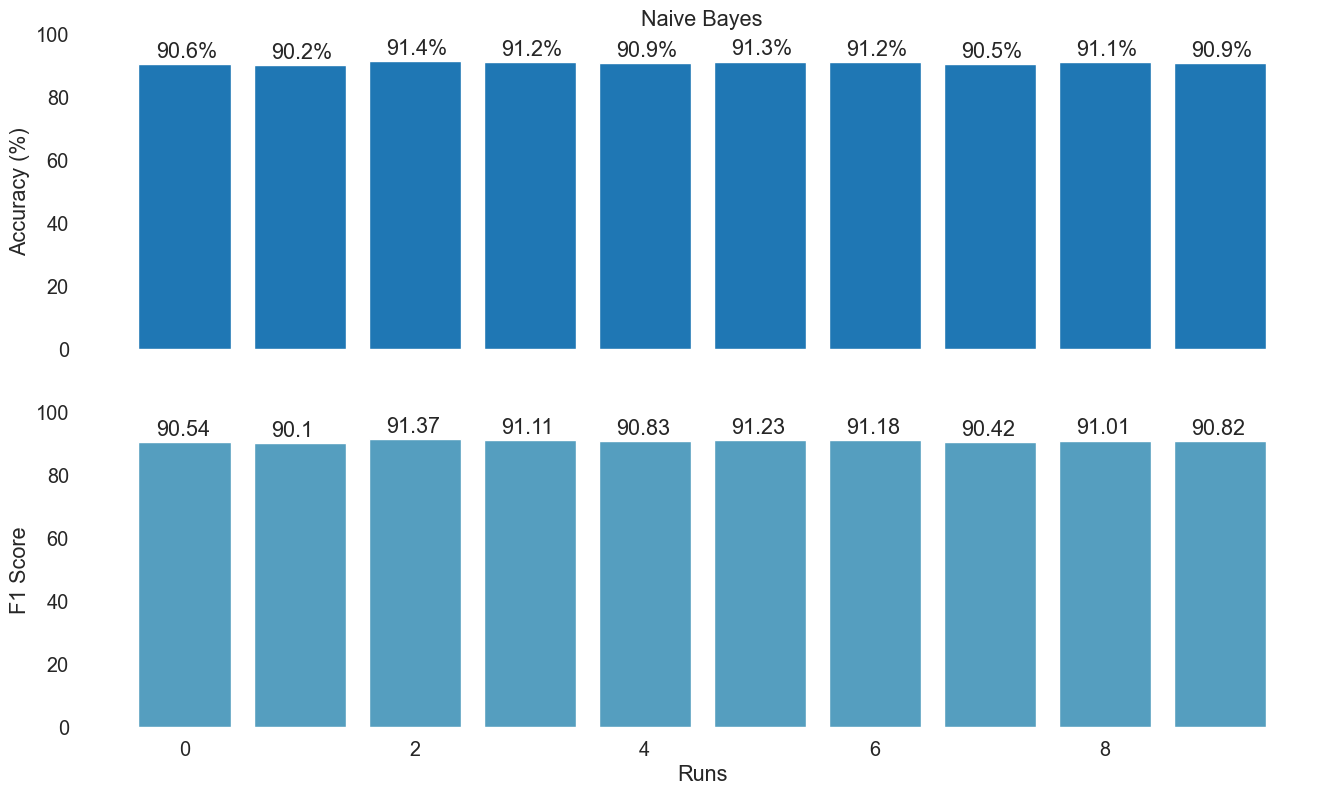

In [82]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9))

acc_scores = [round(a * 100, 1) for a in accs]
f1_scores = [round(f * 100, 2) for f in f1s]

x1 = np.arange(len(acc_scores))
x2 = np.arange(len(f1_scores))

ax1.bar(x1, acc_scores)
ax2.bar(x2, f1_scores, color='#559ebf')

# Place values on top of bars
for i, v in enumerate(list(zip(acc_scores, f1_scores))):
    ax1.text(i - 0.25, v[0] + 2, str(v[0]) + '%')
    ax2.text(i - 0.25, v[1] + 2, str(v[1]))

ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Naive Bayes')
ax1.set_ylim([0, 100])

ax2.set_ylabel('F1 Score')
ax2.set_xlabel('Runs')
ax2.set_ylim([0, 100])

sns.despine(bottom=True, left=True)  # Remove the ticks on axes for cleaner presentation

plt.show()